## Table of Content

- [1.0 - Packages](#1.0)
- [2.0 - Data Pre-processing](#2.0)
- [3.0 - NMSLib: HNSW](#3.0)
- [4.0 - FAISS: Flat Index](#4.0)
- [5.0 - FAISS: IVF Index with PQ](#5.0)
- [6.0 - K-Nearest Neighbors with Dimensionality Reduction](#6.0)
    - [6.1 - Visualization: Principle Components](#6-1)

<a name='1.0'></a>

#### 1.0 PACKAGES

In [ ]:
# !pip install faiss-gpu
!pip install faiss-cpu
!pip install nmslib

In [ ]:
import torch
import time
import torchvision
import ast
import random
import pickle
import faiss
import nmslib
import psutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.image as mpimg

from ast import literal_eval
from plotly.offline import init_notebook_mode
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image, ImageDraw
from tensorflow.keras.preprocessing.image import load_img, img_to_array
%matplotlib inline

<a name='2.0'></a>

#### 2.0 Data Pre-processing

In [ ]:
df_output = pd.read_csv('/content/drive/Othercomputers/My MacBook Pro/google-drive/ctl-dataset/df_w_emb.csv')

In [ ]:
df_output.head(1)

img_path  label  \
0  /content/drive/Othercomputers/My MacBook Pro/g...  Pants   

                                          embeddings  label_id  
0  [-21.73798942565918, 10.553852081298828, -31.5...         0

In [ ]:
# Convert string representations of lists to actual lists
df_output['embeddings'] = df_output['embeddings'].apply(literal_eval)

In [ ]:
image_paths = df_output['img_path'].tolist()

In [ ]:
embeddings = np.array(df_output['embeddings'].tolist())

In [ ]:
def visualize_nearest_neighbors(selected_img_path, nearest_neighbor_paths):
    # Create a figure with two columns
    fig, axs = plt.subplots(5, 2, figsize=(10, 8))

    plt.suptitle("Recommended Items based on your selection", fontsize=16, y=1.03)

    # Display the item selected in the first column (column 0)
    selected_img = mpimg.imread(selected_img_path)
    axs[0, 0].imshow(selected_img)
    axs[0, 0].set_title("Item selected")
    axs[0, 0].axis('off')

    # Limit the number of displayed neighbors to a maximum of 10
    num_neighbors = min(len(nearest_neighbor_paths), 10)

    # Loop through the recommended items (nearest neighbors) and display them in the second column (column 1)
    for i, ax in enumerate(axs[1:].flatten(), 1):
        if i <= num_neighbors:
            neighbor_path = nearest_neighbor_paths[i - 1]
            img = mpimg.imread(neighbor_path)
            ax.imshow(img)
            ax.set_title("Recommended Item")
            ax.axis('off')

    # Hide the axis line in the second column of the first row
    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')

    # Show the images
    plt.show()

In [ ]:
# Function to measure RAM usage
def measure_memory_usage():
    process = psutil.Process()
    start_memory = process.memory_info().rss
    return start_memory

<a name='3.0'></a>

#### 3.0 NMSLib: HNSW

In [ ]:
class NMSLIBIndex():
  def __init__(self, vectors, labels):
    self.dimension = vectors.shape[1]
    self.vectors = vectors.astype('float32')
    self.labels = labels

  def build(self):
    self.index = nmslib.init(method='hnsw', space='cosinesimil')
    self.index.addDataPointBatch(self.vectors)
    self.index.createIndex({'post':4})

  def query(self, vector, k=10):
    indices = self.index.knnQuery(vector, k=k)
    return [self.labels[i] for i in indices[0]]

In [ ]:
index = NMSLIBIndex(embeddings, image_paths)
start_memory = measure_memory_usage()
start = time.time()
index.build()
end = time.time()
end_memory = measure_memory_usage()
ram_consumption = end_memory - start_memory
print(f'{(end - start) * 1000} ms')
print(f'RAM Consumption: {ram_consumption / (1024 * 1024)} MB')

1702.8369903564453 ms
RAM Consumption: 220.62109375 MB


0.5478858947753906 ms


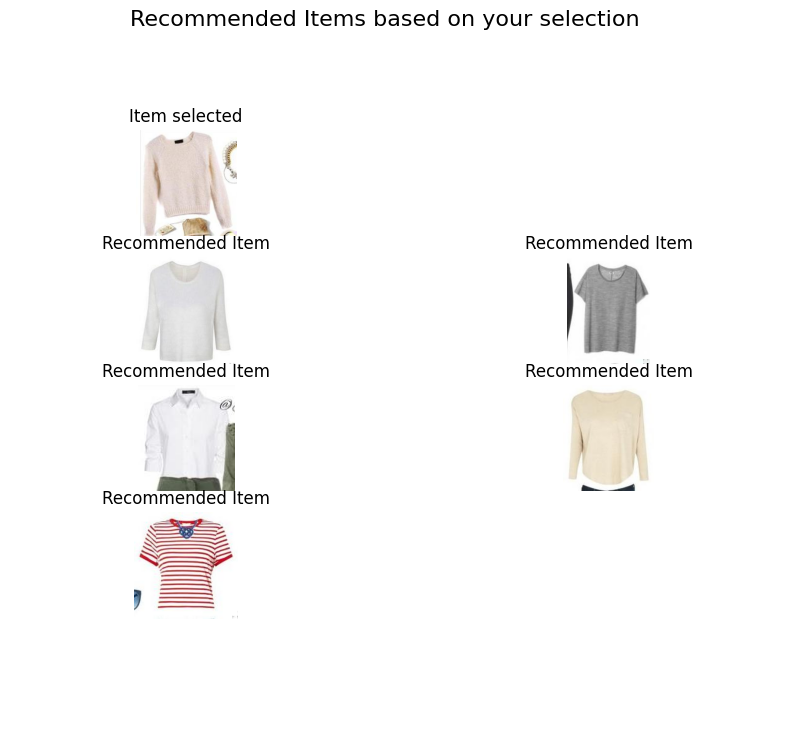

In [ ]:
query_hnsw = [embeddings[12501]]
query_hnsw = np.array(query_hnsw, dtype=np.float32)

# Find the nearest neighbors of the image using its embedding
start = time.time()
nearest_neighbors = index.query(query_hnsw, k=6)
end = time.time()
print(f'{(end - start) * 1000} ms')

selected_neighbor_paths_ = nearest_neighbors[1:]
# Get the path of the selected image from the DataFrame
selected_img_path = image_paths[12501]

visualize_nearest_neighbors(selected_img_path, selected_neighbor_paths_)

0.5855560302734375 ms


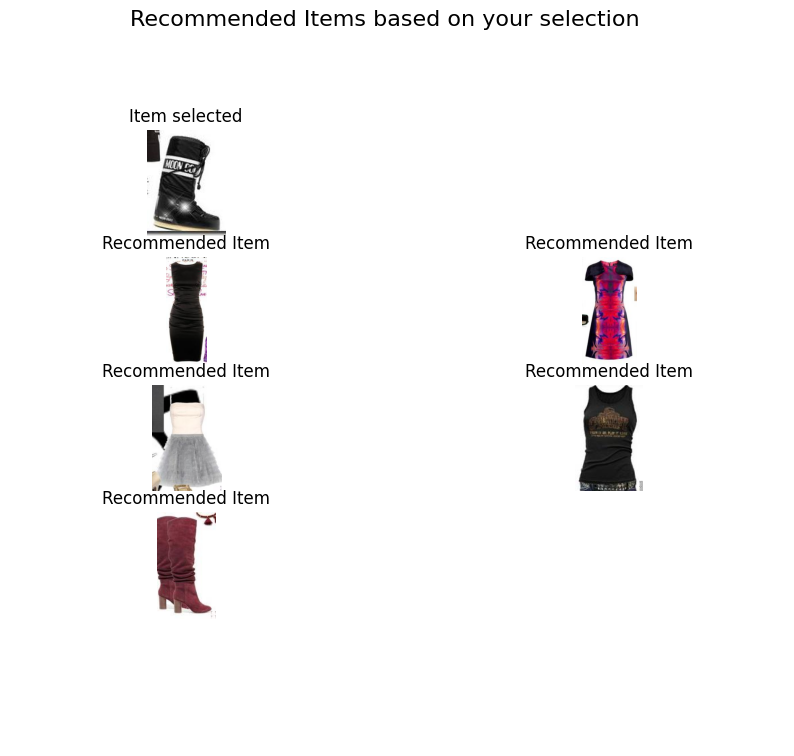

In [ ]:
query_hnsw = [embeddings[43882]]
query_hnsw = np.array(query_hnsw, dtype=np.float32)

# Find the nearest neighbors of the image using its embedding
start = time.time()
nearest_neighbors = index.query(query_hnsw, k=6)
end = time.time()
print(f'{(end - start) * 1000} ms')

selected_neighbor_paths_ = nearest_neighbors[1:]
# Get the path of the selected image from the DataFrame
selected_img_path = image_paths[43882]

visualize_nearest_neighbors(selected_img_path, selected_neighbor_paths_)

0.46133995056152344 ms


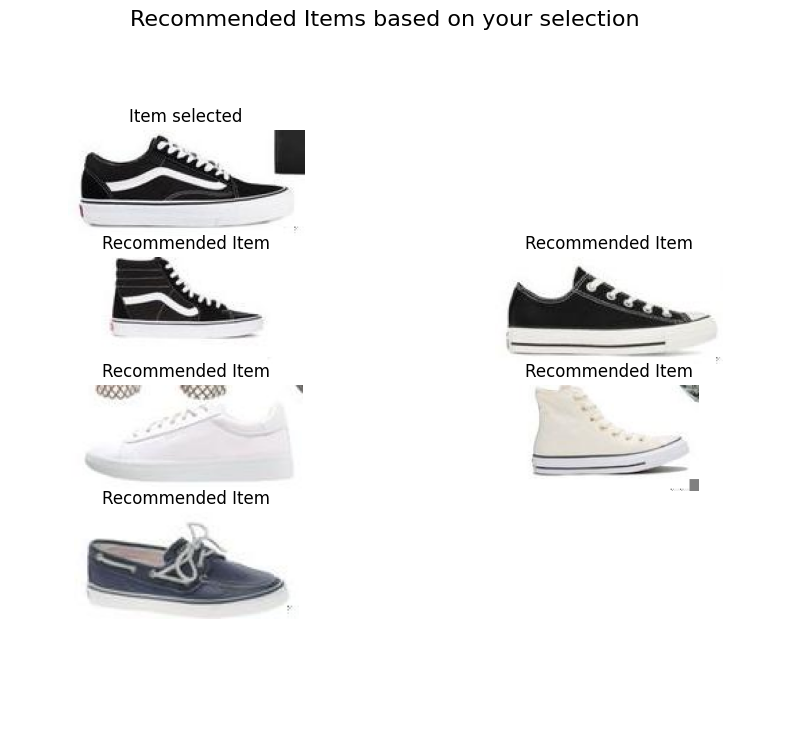

In [ ]:
query_hnsw = [embeddings[7896]]
query_hnsw = np.array(query_hnsw, dtype=np.float32)

# Find the nearest neighbors of the image using its embedding
start = time.time()
nearest_neighbors = index.query(query_hnsw, k=6)
end = time.time()
print(f'{(end - start) * 1000} ms')

selected_neighbor_paths_ = nearest_neighbors[1:]
# Get the path of the selected image from the DataFrame
selected_img_path = image_paths[7896]

visualize_nearest_neighbors(selected_img_path, selected_neighbor_paths_)

<a name='4.0'></a>

#### 4.0 FAISS: Flat Index

In [ ]:
class ExactIndex():
  def __init__(self, vectors, labels):
    self.dimension = vectors.shape[1]
    self.vectors = vectors.astype('float32')
    self.labels = labels

  def build(self):
    self.index = faiss.IndexFlatL2(self.dimension)
    self.index.add(self.vectors)

  def query(self, vectors, k=10):
    distances, indices = self.index.search(vectors, k)
    return [self.labels[i] for i in indices[0]]

In [ ]:
index = ExactIndex(embeddings, image_paths)
start_memory = measure_memory_usage()
start = time.time()
index.build()
end = time.time()
end_memory = measure_memory_usage()
ram_consumption = end_memory - start_memory
print(f'{(end - start) * 1000} ms')
print(f'RAM Consumption: {ram_consumption / (1024 * 1024)} MB')

67.30508804321289 ms
RAM Consumption: 93.22265625 MB


In [ ]:
query_vector = [embeddings[204]]
query_vector = np.array(query_vector, dtype=np.float32)

In [ ]:
# Find the nearest neighbors of the image using its embedding

start = time.time()
nearest_neighbors = index.query(query_vector, k=7)
end = time.time()
print(f'{(end - start) * 1000} ms')

10.523796081542969 ms


In [ ]:
selected_neighbor_paths = nearest_neighbors[1:]

#selected_neighbor_paths = []

#for neighbor in nearest_neighbors:
    #selected_neighbor_paths.append(neighbor)

In [ ]:
# Get the path of the selected image from the DataFrame
selected_img_path = image_paths[204]

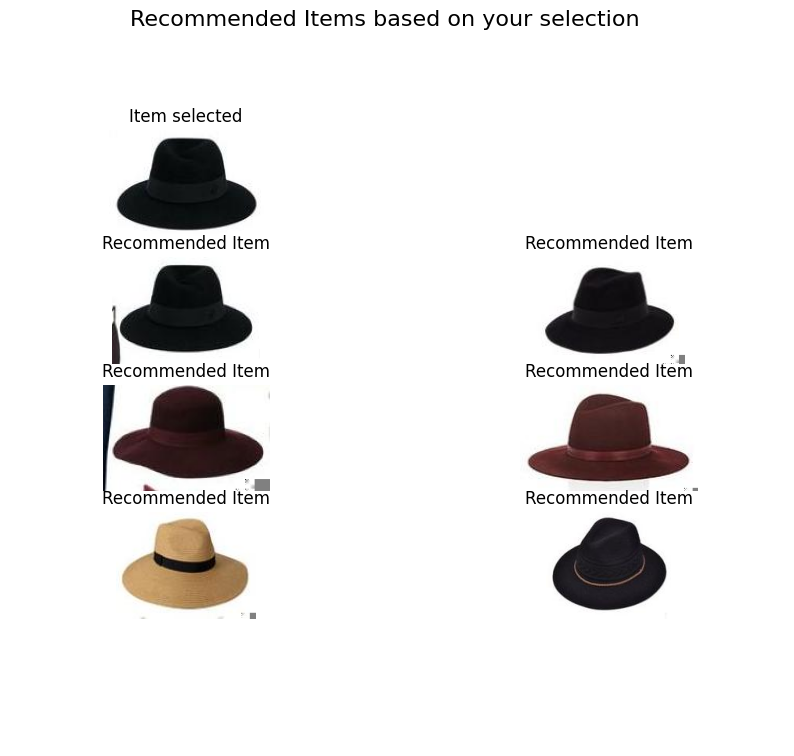

In [ ]:
visualize_nearest_neighbors(selected_img_path, selected_neighbor_paths)

In [ ]:
query_vector = [embeddings[35674]]
query_vector = np.array(query_vector, dtype=np.float32)

In [ ]:
# Find the nearest neighbors of the image using its embedding

start = time.time()
nearest_neighbors = index.query(query_vector, k=6)
end = time.time()
print(f'{(end - start) * 1000} ms')

12.27569580078125 ms


In [ ]:
selected_neighbor_paths_2 = nearest_neighbors[1:]

In [ ]:
# Get the path of the selected image from the DataFrame
selected_img_path = image_paths[35674]

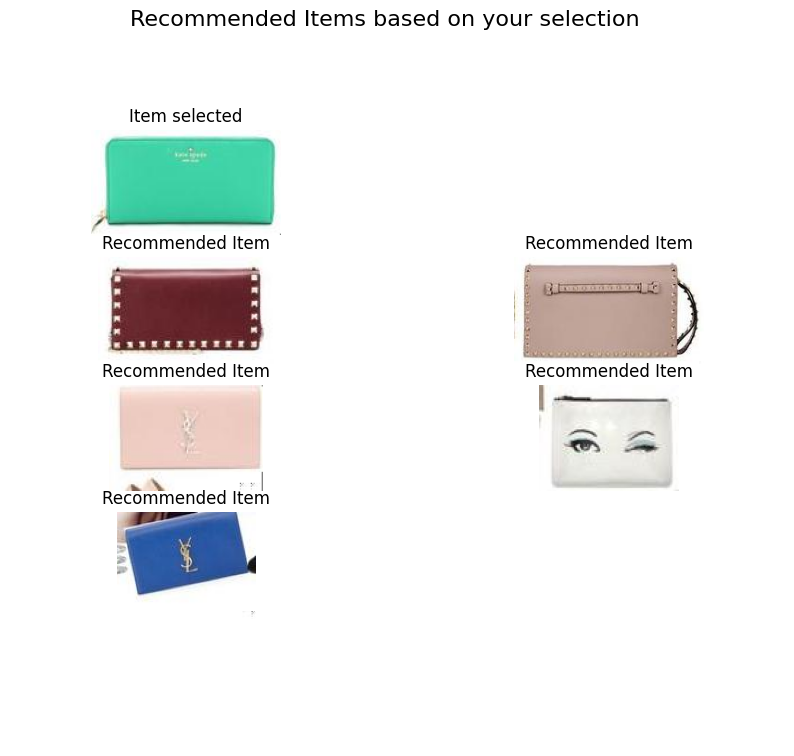

In [ ]:
visualize_nearest_neighbors(selected_img_path, selected_neighbor_paths_2)

11.525869369506836 ms


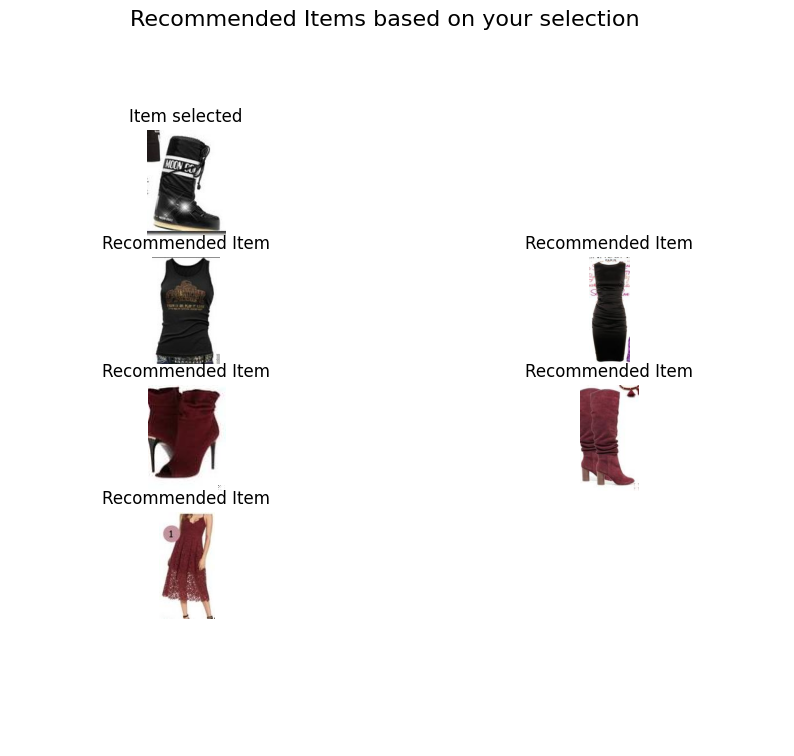

In [ ]:
query_vector = [embeddings[43882]]
query_vector = np.array(query_vector, dtype=np.float32)
start = time.time()
nearest_neighbors = index.query(query_vector, k=6)
end = time.time()
print(f'{(end - start) * 1000} ms')
selected_neighbor_paths_4 = nearest_neighbors[1:]
selected_img_path = image_paths[43882]
visualize_nearest_neighbors(selected_img_path, selected_neighbor_paths_4)

In [ ]:
query_vector = [embeddings[12501]]
query_vector = np.array(query_vector, dtype=np.float32)

In [ ]:
# Find the nearest neighbors of the image using its embedding

start = time.time()
nearest_neighbors = index.query(query_vector, k=6)
end = time.time()
print(f'{(end - start) * 1000} ms')

33.354759216308594 ms


In [ ]:
selected_neighbor_paths_3 = nearest_neighbors[1:]

In [ ]:
# Get the path of the selected image from the DataFrame
selected_img_path = image_paths[12501]

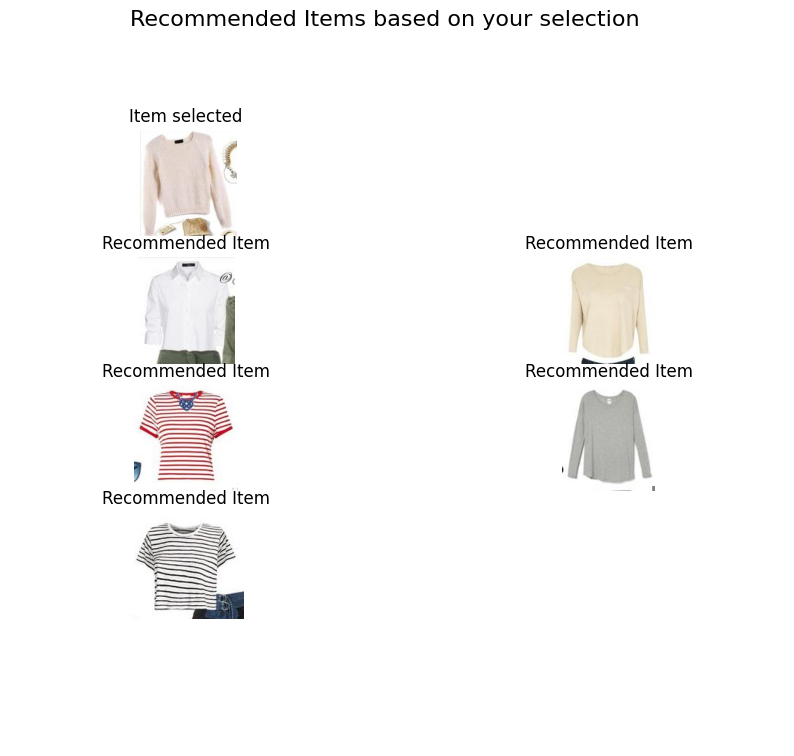

In [ ]:
visualize_nearest_neighbors(selected_img_path, selected_neighbor_paths_3)

12.349605560302734 ms


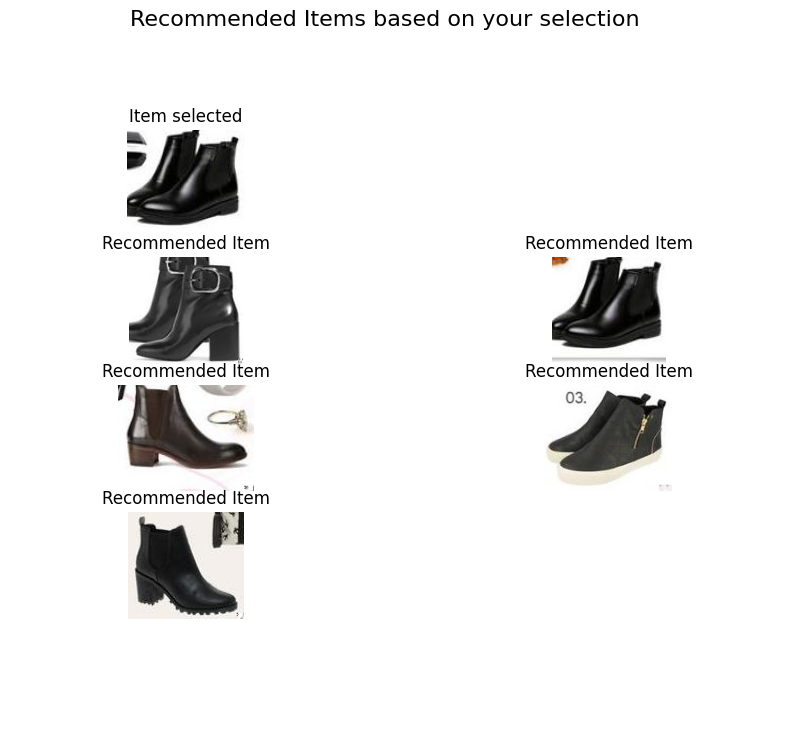

In [ ]:
query_vector = [embeddings[22222]]
query_vector = np.array(query_vector, dtype=np.float32)
start = time.time()
nearest_neighbors = index.query(query_vector, k=6)
end = time.time()
print(f'{(end - start) * 1000} ms')
selected_neighbor_paths_5 = nearest_neighbors[1:]
selected_img_path = image_paths[22222]
visualize_nearest_neighbors(selected_img_path, selected_neighbor_paths_5)

<a name='5.0'></a>

#### 5.0 FAISS: IVF Index with PQ

In [ ]:
class IVPQIndex():
  def __init__(self, vectors, labels):
    self.dimension = vectors.shape[1]
    self.vectors = vectors.astype('float32')
    self.labels = labels

  def build(self, number_of_partition=8,
            search_in_x_partitions=2,
            subvector_size=8):
    quantizer = faiss.IndexFlatL2(self.dimension)
    self.index = faiss.IndexIVFPQ(quantizer,
                                  self.dimension,
                                  number_of_partition,
                                  search_in_x_partitions,
                                  subvector_size)
    self.index.train(self.vectors)
    self.index.add(self.vectors)

  def query(self, vectors, k=10):
    distances, indicies = self.index.search(vectors, k)
    return [self.labels[i] for i in indices[0]]

In [ ]:
index_ivpq = IVPQIndex(embeddings, image_paths)
start_memory = measure_memory_usage()
start = time.time()
index_ivpq.build()
end = time.time()
end_memory = measure_memory_usage()
ram_consumption = end_memory - start_memory
print(f'{(end - start) * 1000} ms')
print(f'RAM Consumption: {ram_consumption / (1024 * 1024)} MB')

6408.407688140869 ms
RAM Consumption: 1.234375 MB


In [ ]:
query_vector = [embeddings[23555]]
query_vector = np.array(query_vector, dtype=np.float32)

In [ ]:
# Find the nearest neighbors of the image using its embedding

start = time.time()
nearest_neighbors = index.query(query_vector, k=7)
end = time.time()
print(f'{(end - start) * 1000} ms')

12.169837951660156 ms


In [ ]:
selected_neighbor_paths_4 = nearest_neighbors[1:]

In [ ]:
# Get the path of the selected image from the DataFrame
selected_img_path = image_paths[23555]

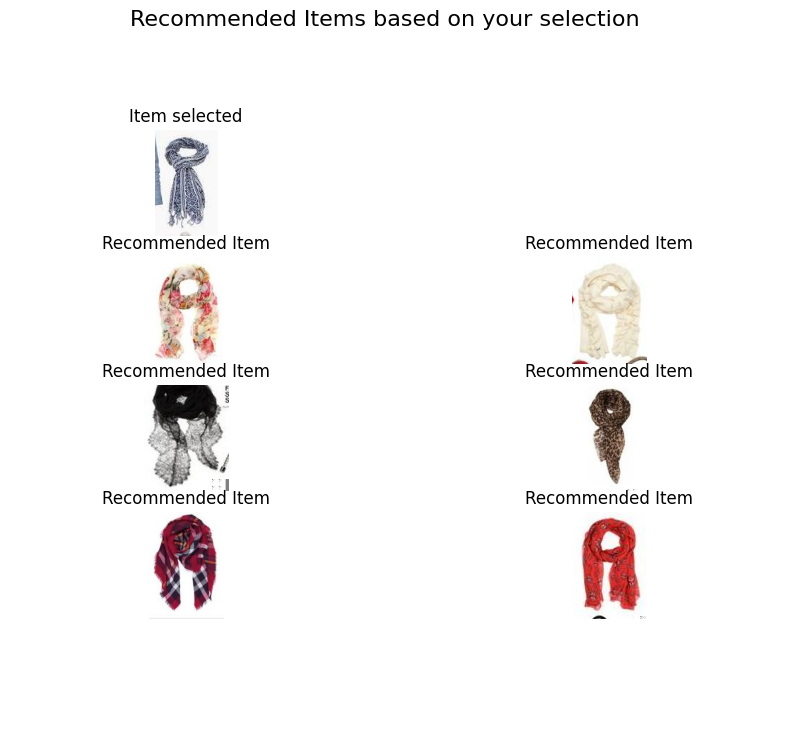

In [ ]:
visualize_nearest_neighbors(selected_img_path, selected_neighbor_paths_4)

34.26408767700195 ms


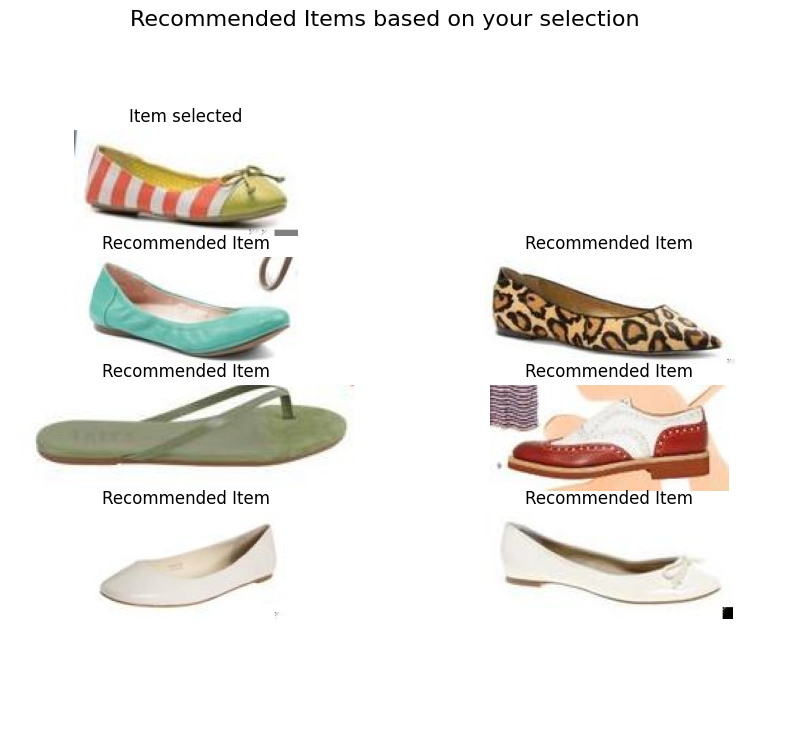

In [ ]:
query_vector = [embeddings[13131]]
query_vector = np.array(query_vector, dtype=np.float32)

# Find the nearest neighbors of the image using its embedding
start = time.time()
nearest_neighbors = index.query(query_vector, k=7)
end = time.time()
print(f'{(end - start) * 1000} ms')

selected_neighbor_paths_5 = nearest_neighbors[1:]
# Get the path of the selected image from the DataFrame
selected_img_path = image_paths[13131]

visualize_nearest_neighbors(selected_img_path, selected_neighbor_paths_5)

34.62624549865723 ms


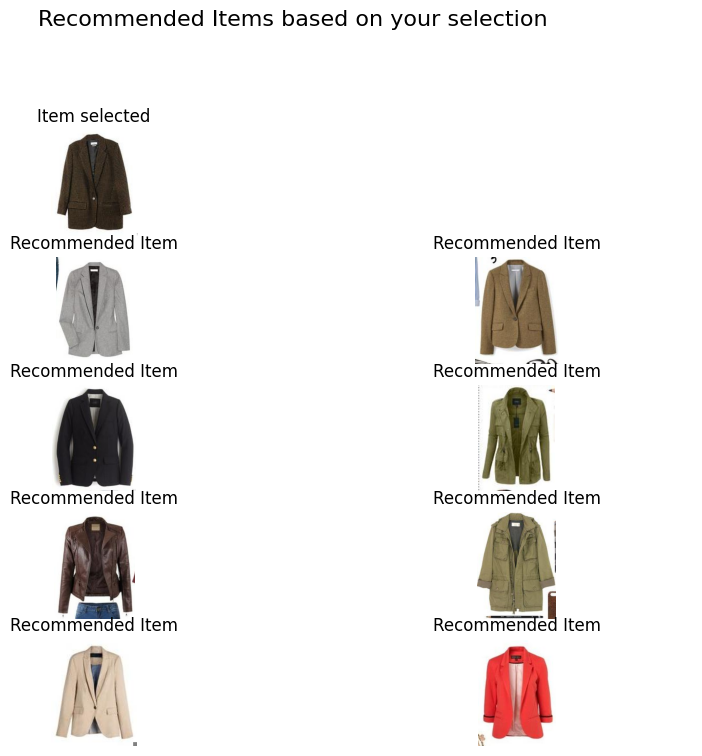

In [ ]:
query_vector = [embeddings[24352]]
query_vector = np.array(query_vector, dtype=np.float32)

# Find the nearest neighbors of the image using its embedding
start = time.time()
nearest_neighbors = index.query(query_vector, k=10)
end = time.time()
print(f'{(end - start) * 1000} ms')

selected_neighbor_paths_6 = nearest_neighbors[1:]
# Get the path of the selected image from the DataFrame
selected_img_path = image_paths[24352]

visualize_nearest_neighbors(selected_img_path, selected_neighbor_paths_6)

9.977340698242188 ms


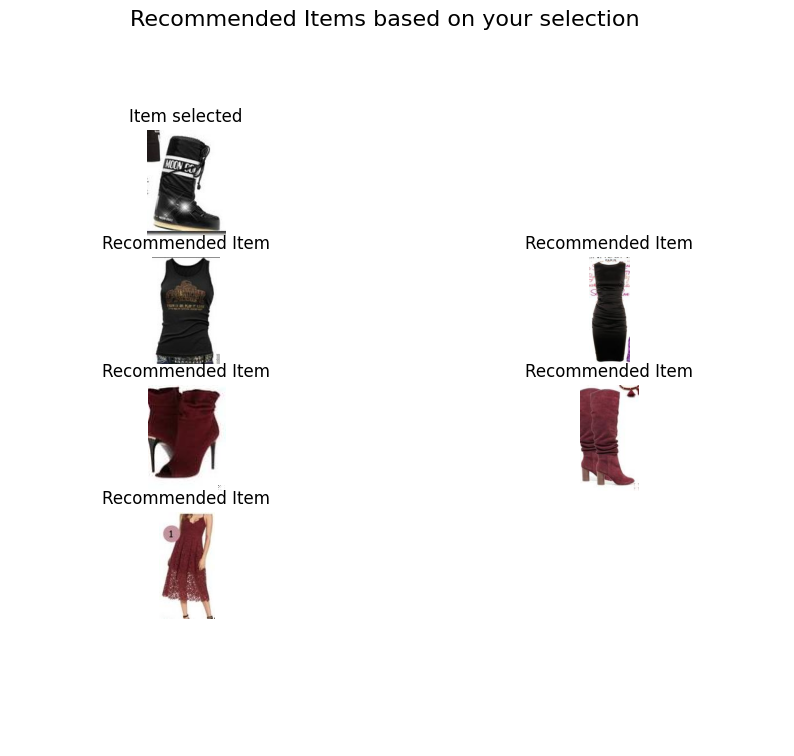

In [ ]:
query_vector = [embeddings[43882]]
query_vector = np.array(query_vector, dtype=np.float32)

# Find the nearest neighbors of the image using its embedding
start = time.time()
nearest_neighbors = index.query(query_vector, k=6)
end = time.time()
print(f'{(end - start) * 1000} ms')

selected_neighbor_paths_6 = nearest_neighbors[1:]
# Get the path of the selected image from the DataFrame
selected_img_path_ = image_paths[43882]

visualize_nearest_neighbors(selected_img_path_, selected_neighbor_paths_6)

<a name='6.0'></a>

#### 6.0 K-Nearest Neighbors with Dimensionality Reduction

In [ ]:
train_df = pd.read_csv('/content/drive/Othercomputers/My MacBook Pro/google-drive/ctl-dataset/new_data/df_w_emb.csv')

In [ ]:
train_df.head(1)

img_path  label  \
0  /content/drive/Othercomputers/My MacBook Pro/g...  Pants   

                                          embeddings  label_id  
0  [-21.73798942565918, 10.553852081298828, -31.5...         0

In [ ]:
train_df['embeddings'] = train_df['embeddings'].apply(ast.literal_eval)

In [ ]:
pca = PCA(2)
pca.fit(train_df['embeddings'].tolist())

PCA(n_components=2)

In [ ]:
train_pca = pca.transform(train_df['embeddings'].tolist())

In [ ]:
train_pca = pd.DataFrame(train_pca)
train_pca.head()

0           1
0 -495.011697  135.067787
1  904.341867 -318.103889
2 -378.691484 -397.261484
3 -388.077980  -57.968810
4 -104.227902   51.705815

In [ ]:
train_df = train_df.merge(train_pca, how='left', left_index=True, right_index=True)

In [ ]:
train_df.head(1)

img_path  label  \
0  /content/drive/Othercomputers/My MacBook Pro/g...  Pants   

                                          embeddings  label_id           0  \
0  [-21.73798942565918, 10.553852081298828, -31.5...         0 -495.011697   

            1  
0  135.067787

In [ ]:
train_df.to_csv('df_w_pca.csv', index=False)

<a name='6.1'></a>

#### 6.1 Visualization: Principle Components

In [ ]:
fig = px.scatter(train_df, x=0, y=1, color='label', title='Categories',
                 height=600,
                 labels={
                    "0": "Principle Component 1",
                    "1": "Principle Component 2"
                 })

fig.show()

In [ ]:
X = train_df.iloc[:, -2:]
y = train_df['img_path']

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X, y)

KNeighborsClassifier(n_neighbors=6)

In [ ]:
def read_img(image_path):
  image = load_img(image_path, target_size=(128, 128, 3))
  image = img_to_array(image)
  image = image/255.
  return image

Time taken to find each recommendeded item: 1.34 ms


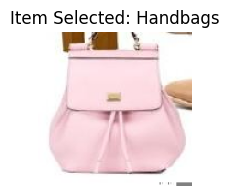

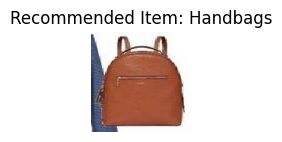

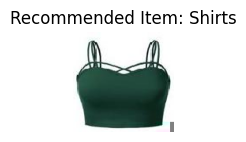

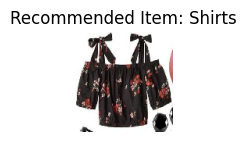

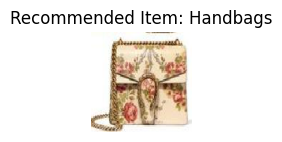

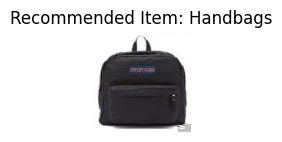

In [ ]:
for _ in range(1):
  i = random.randint(1, len(train_df))
  img1 = read_img(train_df.loc[i, 'img_path'])
  selected_label = train_df.loc[i, 'label']
  start = time.time()
  dist, index = neigh.kneighbors(X=X.iloc[i, :].values.reshape(1, -1))
  end = time.time()

  time_taken_ms = (end - start) * 1000  # Convert to milliseconds
  print(f"Time taken to find each recommendeded item: {time_taken_ms:.2f} ms")

  # Set a common figsize for all subplots
  common_figsize = (8, 8)

  plt.figure(figsize=(2, 2))
  plt.imshow(img1)
  plt.title(f"Item Selected: {selected_label}")
  plt.axis('off')

  for i in range(1, 6):
    plt.figure(figsize=common_figsize)
    plt.subplot(1, 5, i)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    image = read_img(train_df.loc[index[0][i], 'img_path'])
    rec_label = train_df.loc[index[0][i], 'label']
    plt.imshow(image)
    plt.title(f"Recommended Item: {rec_label}")
    plt.axis('off')

plt.show()  # Show the plots
